In [1]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-_7qy2fkk
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-_7qy2fkk
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=3d726cf4d8fba2cd476b6fa332a3fd4c76e1f121fb99a13e02b35e04d90f6036
  Stored in directory: /tmp/pip-ephem-wheel-cache-kp_m9vto/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [3]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

### **Data Exploration**

In [25]:
train_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

print(train_data.data.mean(axis=(0, 1, 2))/255)

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]


In [26]:
len(train_data)

50000

In [27]:
train_data.data.shape

(50000, 32, 32, 3)

### **Transformations**

* **Transformations used on Train Data**
  * Horizontal Flip
  * ShiftScaleRotate
  * Coarse Dropout

* References:
  * [albumentation_doocs](https://albumentations.ai/docs/examples/pytorch_classification/)
  * [video_tutorial](https://www.youtube.com/watch?v=rAdLwKJBvPM&ab_channel=AladdinPersson)
  * [albumentations_classes](https://albumentations.ai/docs/api_reference/augmentations/transforms/)

In [4]:
train_transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, always_apply=False, p=0.5),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
            ToTensorV2(),
        ])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

In [5]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [6]:
train_transform = Transforms(train_transform)
test_transform = Transforms(test_transform)

### **Download And Load Train, Test Data**

In [7]:
train = datasets.CIFAR10(root='./data', train=True,
                        download=True, transform=train_transform)
test = datasets.CIFAR10(root='./data', download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=128,  
                                          shuffle=False,
                                          num_workers=2, 
                                          pin_memory=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


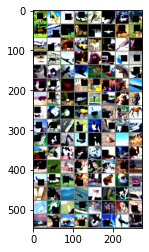

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images["image"]))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

### **Model Design**

In [10]:
class Net(nn.Module):
    def __init__(self, dropout):
      
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False) # 32 32
        )
        self.conv2 = nn.Sequential(
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 32 30
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 30 28
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            #nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 28 26
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )
        # dilation
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (3, 3), stride = 1, padding = 0, dilation=2), # 26 22
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 22 20
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), groups=16, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 20 18
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), groups=32, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 18 16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), groups=64, padding=0, bias=False), #depth_conv
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False), #point_conv
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )
              
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3, 3), stride = 2, padding = 0), # 16 7
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False) # 7 7
        )

        self.conv4 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 7 5
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.Dropout(0.1),
              
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 5 3
            )
        
        self.avgpool2d = nn.AvgPool2d(kernel_size=3)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.avgpool2d(x)
        x = self.conv5(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### **Model Summary**

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(dropout=0.01).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 32, 30, 30]             288
           Conv2d-11           [-1, 32, 30, 30]           1,024
             ReLU-12           [-1, 32, 30, 30]               0
      BatchNorm2d-13           [-1, 32, 30, 30]              64
          Dropout-14           [-1

### **Train Function**

In [13]:
def train(model, device, train_loader, optimizer, epoch,scheduler,criterion):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  train_loss = 0
  
  lambda_l1 = 0.001
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data["image"].to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)

    train_loss += loss.item()

    # Backpropagation
    loss.backward()
        
    optimizer.step()
    scheduler.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc = (100*correct/processed)
  return train_acc, train_loss

### **Test Function**

In [14]:
def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = (100. * correct / len(test_loader.dataset))
    return test_acc, test_loss

### **Train And Test the Model**

In [15]:
dropout=0.01
epochs=90

criterion = nn.CrossEntropyLoss() 

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
    
model = Net(dropout).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)
scheduler = OneCycleLR(optimizer, max_lr=0.015, epochs=90, steps_per_epoch=len(train_loader))

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train_acc, train_loss = train(model, device, train_loader, optimizer,epoch,scheduler,criterion)
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)

    test_acc, test_loss = test(model, device, test_loader,criterion)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1:


Loss=1.9617748260498047 Batch_id=390 Accuracy=18.60: 100%|██████████| 391/391 [00:16<00:00, 23.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 11099/50000 (22.20%)

Epoch 2:


Loss=1.8240715265274048 Batch_id=390 Accuracy=28.88: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 17150/50000 (34.30%)

Epoch 3:


Loss=1.6940200328826904 Batch_id=390 Accuracy=34.10: 100%|██████████| 391/391 [00:16<00:00, 24.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 20488/50000 (40.98%)

Epoch 4:


Loss=1.5552923679351807 Batch_id=390 Accuracy=37.93: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 22092/50000 (44.18%)

Epoch 5:


Loss=1.642897605895996 Batch_id=390 Accuracy=41.19: 100%|██████████| 391/391 [00:16<00:00, 24.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 24544/50000 (49.09%)

Epoch 6:


Loss=1.509184718132019 Batch_id=390 Accuracy=43.58: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 25986/50000 (51.97%)

Epoch 7:


Loss=1.4026966094970703 Batch_id=390 Accuracy=46.18: 100%|██████████| 391/391 [00:16<00:00, 24.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 27268/50000 (54.54%)

Epoch 8:


Loss=1.5222337245941162 Batch_id=390 Accuracy=47.90: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 27095/50000 (54.19%)

Epoch 9:


Loss=1.1760590076446533 Batch_id=390 Accuracy=48.98: 100%|██████████| 391/391 [00:16<00:00, 24.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 29388/50000 (58.78%)

Epoch 10:


Loss=1.2728935480117798 Batch_id=390 Accuracy=50.41: 100%|██████████| 391/391 [00:16<00:00, 24.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 29796/50000 (59.59%)

Epoch 11:


Loss=1.292845368385315 Batch_id=390 Accuracy=51.59: 100%|██████████| 391/391 [00:16<00:00, 24.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 29774/50000 (59.55%)

Epoch 12:


Loss=1.2440195083618164 Batch_id=390 Accuracy=52.93: 100%|██████████| 391/391 [00:16<00:00, 24.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 31464/50000 (62.93%)

Epoch 13:


Loss=1.4440639019012451 Batch_id=390 Accuracy=53.98: 100%|██████████| 391/391 [00:16<00:00, 24.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 32028/50000 (64.06%)

Epoch 14:


Loss=1.4682139158248901 Batch_id=390 Accuracy=54.83: 100%|██████████| 391/391 [00:16<00:00, 24.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 32036/50000 (64.07%)

Epoch 15:


Loss=1.4051693677902222 Batch_id=390 Accuracy=55.80: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 32941/50000 (65.88%)

Epoch 16:


Loss=1.3370463848114014 Batch_id=390 Accuracy=56.74: 100%|██████████| 391/391 [00:16<00:00, 23.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 33581/50000 (67.16%)

Epoch 17:


Loss=1.0382769107818604 Batch_id=390 Accuracy=57.55: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 33713/50000 (67.43%)

Epoch 18:


Loss=1.0502631664276123 Batch_id=390 Accuracy=58.08: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 33880/50000 (67.76%)

Epoch 19:


Loss=1.0337384939193726 Batch_id=390 Accuracy=59.22: 100%|██████████| 391/391 [00:16<00:00, 24.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 33787/50000 (67.57%)

Epoch 20:


Loss=1.1833324432373047 Batch_id=390 Accuracy=59.65: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 35394/50000 (70.79%)

Epoch 21:


Loss=1.0973570346832275 Batch_id=390 Accuracy=60.32: 100%|██████████| 391/391 [00:16<00:00, 23.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 35225/50000 (70.45%)

Epoch 22:


Loss=1.1229403018951416 Batch_id=390 Accuracy=60.71: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 35078/50000 (70.16%)

Epoch 23:


Loss=1.022588849067688 Batch_id=390 Accuracy=61.74: 100%|██████████| 391/391 [00:16<00:00, 23.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 36221/50000 (72.44%)

Epoch 24:


Loss=1.0384981632232666 Batch_id=390 Accuracy=62.38: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 36080/50000 (72.16%)

Epoch 25:


Loss=1.012056589126587 Batch_id=390 Accuracy=62.89: 100%|██████████| 391/391 [00:16<00:00, 23.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 36488/50000 (72.98%)

Epoch 26:


Loss=1.214317798614502 Batch_id=390 Accuracy=62.97: 100%|██████████| 391/391 [00:16<00:00, 24.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 36395/50000 (72.79%)

Epoch 27:


Loss=0.9769196510314941 Batch_id=390 Accuracy=63.44: 100%|██████████| 391/391 [00:16<00:00, 24.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 36236/50000 (72.47%)

Epoch 28:


Loss=1.067617416381836 Batch_id=390 Accuracy=64.13: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 37129/50000 (74.26%)

Epoch 29:


Loss=1.0719388723373413 Batch_id=390 Accuracy=64.51: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 37277/50000 (74.55%)

Epoch 30:


Loss=1.0482361316680908 Batch_id=390 Accuracy=64.72: 100%|██████████| 391/391 [00:16<00:00, 24.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 37019/50000 (74.04%)

Epoch 31:


Loss=0.8320412635803223 Batch_id=390 Accuracy=65.20: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 37599/50000 (75.20%)

Epoch 32:


Loss=0.8156550526618958 Batch_id=390 Accuracy=65.19: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 38794/50000 (77.59%)

Epoch 33:


Loss=0.9869725108146667 Batch_id=390 Accuracy=65.69: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 38497/50000 (76.99%)

Epoch 34:


Loss=0.7811394929885864 Batch_id=390 Accuracy=66.04: 100%|██████████| 391/391 [00:16<00:00, 24.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 38473/50000 (76.95%)

Epoch 35:


Loss=0.7895585894584656 Batch_id=390 Accuracy=66.30: 100%|██████████| 391/391 [00:16<00:00, 23.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 39075/50000 (78.15%)

Epoch 36:


Loss=1.0878249406814575 Batch_id=390 Accuracy=66.68: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39113/50000 (78.23%)

Epoch 37:


Loss=0.754012942314148 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 38931/50000 (77.86%)

Epoch 38:


Loss=1.1218807697296143 Batch_id=390 Accuracy=67.05: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 39138/50000 (78.28%)

Epoch 39:


Loss=0.7922338247299194 Batch_id=390 Accuracy=67.44: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 39336/50000 (78.67%)

Epoch 40:


Loss=0.867035984992981 Batch_id=390 Accuracy=67.84: 100%|██████████| 391/391 [00:16<00:00, 23.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 39343/50000 (78.69%)

Epoch 41:


Loss=1.1128127574920654 Batch_id=390 Accuracy=67.98: 100%|██████████| 391/391 [00:16<00:00, 23.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 39313/50000 (78.63%)

Epoch 42:


Loss=0.8835676312446594 Batch_id=390 Accuracy=67.97: 100%|██████████| 391/391 [00:16<00:00, 23.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 39642/50000 (79.28%)

Epoch 43:


Loss=0.887199878692627 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 39634/50000 (79.27%)

Epoch 44:


Loss=0.9129770994186401 Batch_id=390 Accuracy=67.97: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 39953/50000 (79.91%)

Epoch 45:


Loss=0.879075825214386 Batch_id=390 Accuracy=68.47: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39759/50000 (79.52%)

Epoch 46:


Loss=0.8798263669013977 Batch_id=390 Accuracy=68.94: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 39757/50000 (79.51%)

Epoch 47:


Loss=0.9070954322814941 Batch_id=390 Accuracy=69.10: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 39749/50000 (79.50%)

Epoch 48:


Loss=0.9693851470947266 Batch_id=390 Accuracy=69.19: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 39987/50000 (79.97%)

Epoch 49:


Loss=0.8708375692367554 Batch_id=390 Accuracy=69.33: 100%|██████████| 391/391 [00:16<00:00, 23.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 40178/50000 (80.36%)

Epoch 50:


Loss=1.1177469491958618 Batch_id=390 Accuracy=69.82: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40749/50000 (81.50%)

Epoch 51:


Loss=0.6330642104148865 Batch_id=390 Accuracy=69.92: 100%|██████████| 391/391 [00:16<00:00, 23.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40645/50000 (81.29%)

Epoch 52:


Loss=0.7560447454452515 Batch_id=390 Accuracy=69.79: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40669/50000 (81.34%)

Epoch 53:


Loss=0.8890754580497742 Batch_id=390 Accuracy=69.72: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40877/50000 (81.75%)

Epoch 54:


Loss=1.0481340885162354 Batch_id=390 Accuracy=69.96: 100%|██████████| 391/391 [00:16<00:00, 23.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40835/50000 (81.67%)

Epoch 55:


Loss=0.9756792187690735 Batch_id=390 Accuracy=70.07: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 40578/50000 (81.16%)

Epoch 56:


Loss=1.1141549348831177 Batch_id=390 Accuracy=70.41: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 40823/50000 (81.65%)

Epoch 57:


Loss=0.763458251953125 Batch_id=390 Accuracy=70.49: 100%|██████████| 391/391 [00:16<00:00, 24.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41129/50000 (82.26%)

Epoch 58:


Loss=0.8565123677253723 Batch_id=390 Accuracy=70.27: 100%|██████████| 391/391 [00:16<00:00, 24.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 41287/50000 (82.57%)

Epoch 59:


Loss=0.6991275548934937 Batch_id=390 Accuracy=70.80: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 41601/50000 (83.20%)

Epoch 60:


Loss=1.1233488321304321 Batch_id=390 Accuracy=70.94: 100%|██████████| 391/391 [00:16<00:00, 23.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 41303/50000 (82.61%)

Epoch 61:


Loss=0.6903630495071411 Batch_id=390 Accuracy=71.33: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 41142/50000 (82.28%)

Epoch 62:


Loss=0.8220556378364563 Batch_id=390 Accuracy=71.47: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 41479/50000 (82.96%)

Epoch 63:


Loss=0.7586281299591064 Batch_id=390 Accuracy=71.52: 100%|██████████| 391/391 [00:16<00:00, 23.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41819/50000 (83.64%)

Epoch 64:


Loss=1.0481477975845337 Batch_id=390 Accuracy=71.44: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41932/50000 (83.86%)

Epoch 65:


Loss=0.8157222867012024 Batch_id=390 Accuracy=71.89: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41884/50000 (83.77%)

Epoch 66:


Loss=0.7052044868469238 Batch_id=390 Accuracy=72.15: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 42079/50000 (84.16%)

Epoch 67:


Loss=0.7799423933029175 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [00:16<00:00, 23.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41947/50000 (83.89%)

Epoch 68:


Loss=0.8780487179756165 Batch_id=390 Accuracy=72.03: 100%|██████████| 391/391 [00:16<00:00, 23.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 42018/50000 (84.04%)

Epoch 69:


Loss=0.6862533688545227 Batch_id=390 Accuracy=72.53: 100%|██████████| 391/391 [00:16<00:00, 23.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42383/50000 (84.77%)

Epoch 70:


Loss=0.8790459632873535 Batch_id=390 Accuracy=72.49: 100%|██████████| 391/391 [00:16<00:00, 23.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42170/50000 (84.34%)

Epoch 71:


Loss=0.7624297142028809 Batch_id=390 Accuracy=72.52: 100%|██████████| 391/391 [00:16<00:00, 23.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42308/50000 (84.62%)

Epoch 72:


Loss=0.827390193939209 Batch_id=390 Accuracy=72.96: 100%|██████████| 391/391 [00:16<00:00, 23.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42574/50000 (85.15%)

Epoch 73:


Loss=0.8999192118644714 Batch_id=390 Accuracy=72.92: 100%|██████████| 391/391 [00:16<00:00, 23.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 42245/50000 (84.49%)

Epoch 74:


Loss=0.7837992906570435 Batch_id=390 Accuracy=72.94: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 42555/50000 (85.11%)

Epoch 75:


Loss=0.84306401014328 Batch_id=390 Accuracy=73.16: 100%|██████████| 391/391 [00:16<00:00, 23.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42601/50000 (85.20%)

Epoch 76:


Loss=0.6454547643661499 Batch_id=390 Accuracy=73.31: 100%|██████████| 391/391 [00:16<00:00, 24.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42755/50000 (85.51%)

Epoch 77:


Loss=0.7639096975326538 Batch_id=390 Accuracy=73.51: 100%|██████████| 391/391 [00:16<00:00, 23.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42694/50000 (85.39%)

Epoch 78:


Loss=0.8150988817214966 Batch_id=390 Accuracy=74.03: 100%|██████████| 391/391 [00:16<00:00, 23.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 42787/50000 (85.57%)

Epoch 79:


Loss=0.7749282717704773 Batch_id=390 Accuracy=73.74: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42901/50000 (85.80%)

Epoch 80:


Loss=0.8054191470146179 Batch_id=390 Accuracy=74.18: 100%|██████████| 391/391 [00:16<00:00, 23.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42933/50000 (85.87%)

Epoch 81:


Loss=0.7883496284484863 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:16<00:00, 23.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 42899/50000 (85.80%)

Epoch 82:


Loss=0.7530765533447266 Batch_id=390 Accuracy=73.91: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 43028/50000 (86.06%)

Epoch 83:


Loss=0.6697109341621399 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 43051/50000 (86.10%)

Epoch 84:


Loss=0.6346662640571594 Batch_id=390 Accuracy=74.24: 100%|██████████| 391/391 [00:16<00:00, 23.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 43078/50000 (86.16%)

Epoch 85:


Loss=0.7280442714691162 Batch_id=390 Accuracy=74.39: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43149/50000 (86.30%)

Epoch 86:


Loss=0.8343936204910278 Batch_id=390 Accuracy=74.51: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43169/50000 (86.34%)

Epoch 87:


Loss=0.7086585760116577 Batch_id=390 Accuracy=74.74: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43167/50000 (86.33%)

Epoch 88:


Loss=0.8070831298828125 Batch_id=390 Accuracy=74.54: 100%|██████████| 391/391 [00:16<00:00, 23.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43179/50000 (86.36%)

Epoch 89:


Loss=0.8599007725715637 Batch_id=390 Accuracy=74.78: 100%|██████████| 391/391 [00:16<00:00, 23.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 43214/50000 (86.43%)

Epoch 90:


Loss=0.693084716796875 Batch_id=390 Accuracy=75.02: 100%|██████████| 391/391 [00:16<00:00, 23.62it/s]



Test set: Average loss: 0.0031, Accuracy: 43237/50000 (86.47%)



### **Train, Validation Loss and Accuracy Plots**

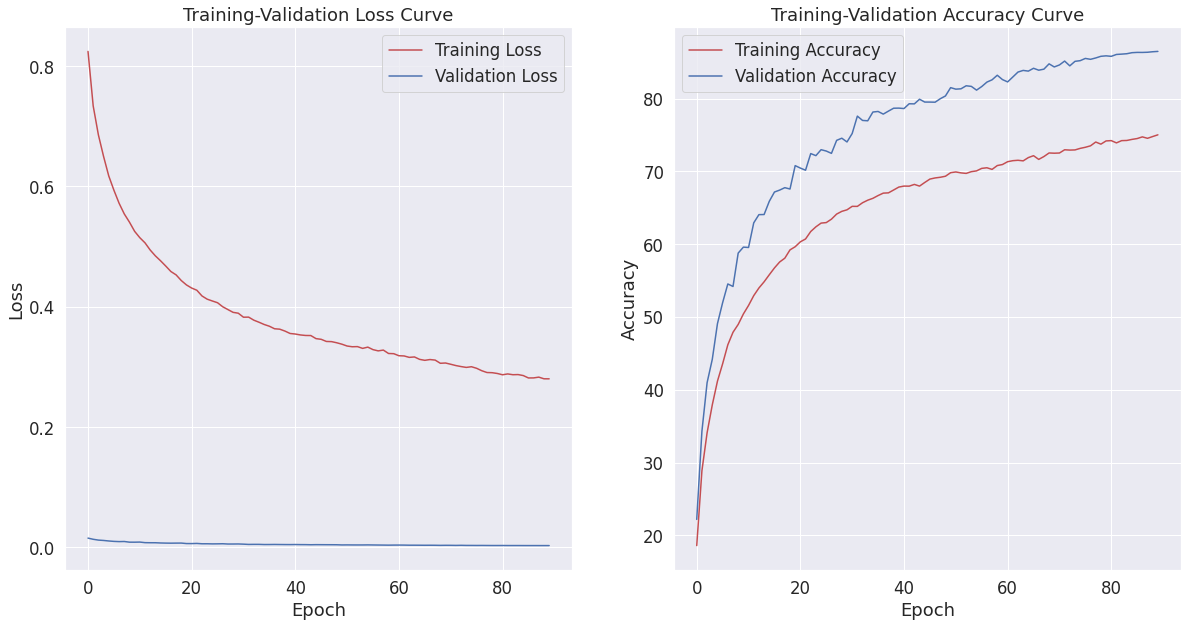

In [22]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(np.array([x/1000 for x in train_losses ]), 'r', label="Training Loss")
plt1.plot(np.array(test_losses), 'b', label="Validation Loss")
plt2.plot(np.array(train_accuracy), 'r', label="Training Accuracy")
plt2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Class Wise Performance**

In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 94 %
Accuracy of  bird : 78 %
Accuracy of   cat : 74 %
Accuracy of  deer : 86 %
Accuracy of   dog : 72 %
Accuracy of  frog : 90 %
Accuracy of horse : 80 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %


In [33]:
!pip install receptivefield>=0.5.0

In [32]:
from torch_receptive_field import receptive_field
receptive_field(model, input_size=(channels, H, W))

ModuleNotFoundError: ignored